In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

Convolutional neural nets are notoriously difficult to interpret. One strategy for interpreting them can be taken from the field that spawned them, systems and computational neuroscience. To take its responses to a set of relevant stimuli, then attempt to group the responses into types or dimensions. For example based upon the responses of neurons to stimuli Hubel and Wiesel created two categories, simple and complex cells. While the majority of cells are rarely perfectly idealized versions of either grouping, a great deal of their variation can be explained by determining where they sit along the axis of simple to complex. This reduction in dimensionality from the many neurons that exist in V1 to a single dimension of variation that is fairly predictive is a win for human understanding of V1.

Furthermore they built upon the categorization of responses in LGN which had been largely categorized as center surround, to develop a theory of the response properties along this dimension with respect to the spatial positioning and wiring of cells in LGN.

The general pattern here is one looks at fundamental units of computation in the nervous system, the neuron, in a given region of the brain with the expectation these units will be performing similar computations modulo some transformation (rotation, translation, scaling, etc), discovers this computation, then when interpreting processes that depend on that computation is able to understand them and group them w.r.t. the reduction in dimensionality for that region.

We will follow a similar pattern for interpreting a convolutional neural net. At each stage of the net we will search for some canonical computations, that can be described by a few variables, then in the next stage we will perform our interpretation with respect to those variables. We will begin with the first layer, making a tally of the structure and groupings we see in the weights of these filters, with which to then interpret the filters on their outputs of the second layer.

In [2]:
import pickle
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline  
top_dir = os.getcwd().split('ipython_nb')[0]
# sys.path.append(top_dir + 'xarray')
sys.path.append(top_dir)
# sys.path.append(top_dir + 'common')
# import xarray as xr
from mpl_toolkits.axes_grid1 import make_axes_locatable
# import d_img_process as di
# import d_misc as dm

def beautify(ax=None, spines_to_remove = ['top', 'right']):
    almost_black = '#262626'
    more_grey = '#929292'
#    text_font = 'serif'
#    number_font = 'helvetica'
    all_spines = ['bottom','left','right','top']
    # Get the axes.
    if ax is None:
        #fig = plt.figure(1)
        ax = plt.axes()
    if not type(ax)==type([]):
        ax = [ax,]
    for a_ax in ax:
        # Remove 'spines' (axis lines)
        for spine in spines_to_remove:
            a_ax.spines[spine].set_visible(False)
    
        # Make ticks only where there are spines
        if 'left' in spines_to_remove:
            a_ax.tick_params(left=0)
        if 'right'  in spines_to_remove:
            a_ax.tick_params(right=0)
        if 'bottom'  in spines_to_remove:
            a_ax.tick_params(bottom=0)
        if 'top'  in spines_to_remove:
            a_ax.tick_params(top=0)
    
        # Now make them go 'out' rather than 'in'
        for axis in ['x', 'y']:
            a_ax.tick_params(axis=axis, which='both', direction='out', pad=7)
            a_ax.tick_params(axis=axis, which='major', color=almost_black, length=6)
            a_ax.tick_params(axis=axis, which='minor', color=more_grey, length=4)
    
        # Make thinner and off-black
        spines_to_keep = list(set(all_spines) - set(spines_to_remove))
        
        for spine in spines_to_keep:
            a_ax.spines[spine].set_linewidth(0.5)
            a_ax.spines[spine].set_color(almost_black)

    
        # Change the labels & title to the off-black and change their font
        for label in [a_ax.yaxis.label, a_ax.xaxis.label, a_ax.title]:
            label.set_color(almost_black)
    
        # Change the tick labels' color and font and padding
        for axis in [a_ax.yaxis, a_ax.xaxis]:
            # padding
            axis.labelpad = 20
            # major ticks
            for major_tick in axis.get_major_ticks():
                label = major_tick.label
                label.set_color(almost_black)
            # minor ticks
            for minor_tick in axis.get_minor_ticks():
                label = minor_tick.label
                label.set_color(more_grey)

    #plt.grid(axis='y', color=more_grey)
def d_cust_hist(ax, n, bins, color='k', lw=1):
    for a_n, a_bin in zip(n, bins):
        ax.plot([a_bin,a_bin],[0, a_n], color=color, lw=lw, linestyle=':', alpha=0.7)
    for i, a_n in enumerate(n):
        ax.plot([bins[i], bins[i+1]], [a_n, a_n],color=color, lw=lw)     
    
def d_hist(ax, x, bins='auto', alpha=0.5, color='k', lw=1, normed=True, cumulative=False):
     
    if bins=='auto':
        bins = np.round(np.sqrt(len(x))/2)
    if cumulative:
        if not all(np.isnan(x)):
            y_cum = np.array(range(1,len(x)+1))/float(len(x))
            ax.step(np.sort(x), y_cum, 
                    alpha=alpha,  color=color, lw=lw)
            ax.scatter([np.max(x)], [1,], color=color, marker='|')
            n = y_cum
            bins = np.sort(x)
        else:
            bins = None
            n = None
    else:
        n, bins = np.histogram(x, bins=bins, normed=True)
        d_cust_hist(ax, n, bins=bins, color=color, lw=lw)
        #n, bins, _ = ax.hist(x, bins=bins, color=color, histtype='step', 
        #                 alpha=alpha, lw=1, normed=normed)
        
    return n, bins
import itertools
flatten_iter = itertools.chain.from_iterable
def factors(n):
    return set(flatten_iter((i, n//i) 
                for i in range(1, int(n**0.5)+1) if n % i == 0))
goforit=True       
if 'a' not in locals() or goforit:
    with open(top_dir + '/netwts.p', 'rb') as f:    
        try:
            a = pickle.load(f, encoding='latin1')
        except:
            a = pickle.load(f)


def vis_square(ax, data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    ax.imshow(data, interpolation='nearest'); ax.axis('off')

In [14]:
# get feature mapping for all 118 images 
# use inception to transform raw input
import mxnet as mx

# Load the pre-trained model
# need to download the following files from https://github.com/dmlc/mxnet-model-gallery/blob/master/imagenet-1k-vgg.md
# vgg16-symbol.json: symbolic network
# vgg16-0000.params: network parameter, need to rename it as vgg16-0001.params

prefix = "/home/iris/mydata/mxnet/models/vgg16/vgg16"
num_round = 1
model = mx.model.FeedForward.load(prefix, num_round, ctx=mx.cpu(), numpy_batch_size=1)

In [4]:
a = []
keys = [k for k in model.arg_params]
keys = sorted(keys)
for j in range(len(keys)/2):
    tmp = [model.arg_params[keys[2*j]].asnumpy(), model.arg_params[keys[2*j+1]].asnumpy()]
    a.append(tmp)

Lets start by visualizing the filters in the first layer. Luckily these filters only have 3 channels, thus we can see all channels at once, and these channels correspond to R, G, and B so we are actually seeing what these filters will respond best to in an image. 

First layer weight dims:(64, 3, 3, 3)
Second layer weight dims:(64, 64, 3, 3)


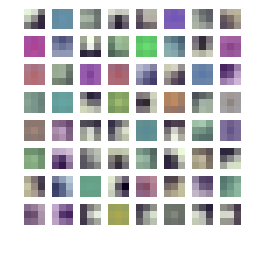

In [7]:
ax = plt.subplot(111)
wts = np.transpose(a[0][1], (0,2,3,1))
print('First layer weight dims:' + str(a[0][1].shape))
vis_square(ax, wts)
print('Second layer weight dims:' +  str(a[1][1].shape))

Figure 1.
Here we plot the 1st layer filters with the range across filters set to their max range, thus filters with lower contrast correspond to filters with less variance than the others. The first striking observation is that the top 48 seem largely black and white, and the bottom tend to be more colorful. 

<h4>Chromaticity</h4>
Lets make that observation quantitative by making a chromaticity index, where we will ask what fraction of the power of the $n$ channels in a given filter:
$$\vec{x}_i = \left[
\begin{array}{ccc}
R  \\
G \\
B 
\end{array}
\right]$$
cannot be explained by:
$$\vec{\mu} = \mu \left[
\begin{array}{ccc}
1  \\
1 \\
1 
\end{array}
\right]$$

Thus our chromaticity index $c$ will be:
$$c = \frac{\sum_i^n{(\vec{x}_i - \frac{1}{n}\sum_i^n{\vec{x}_i})^2}}{\sum_i^n{\vec{x}_i}^2}$$

or in other words the sample variance of each channel divided by the total power in all channels. Thus an index of one would imply across channels a mean of 0, and an index of 1 would imply across channels there was no variance.

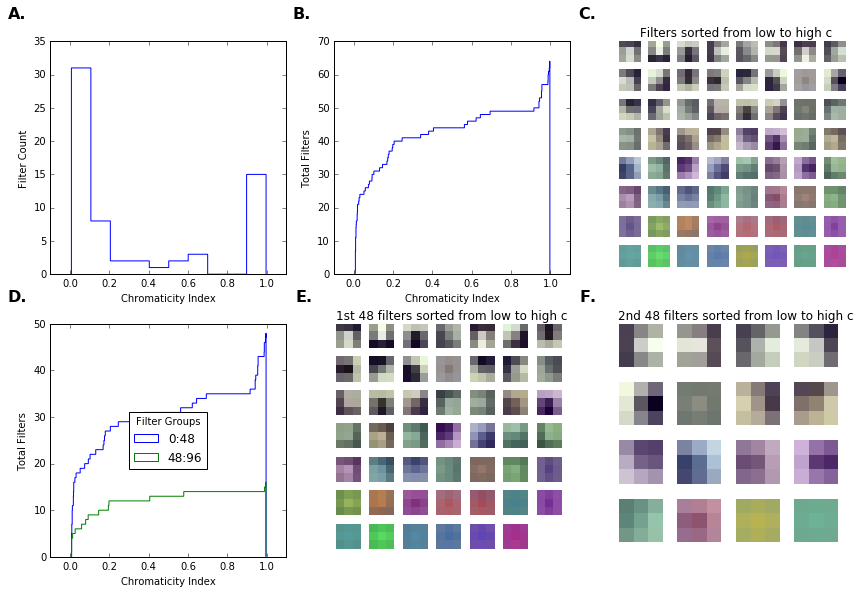

In [8]:
def chrom_index(im):
    im_power = np.sum(im**2)
    im_var = np.sum((im - np.mean(im, -1, keepdims=True))**2)
    return im_var/im_power
wts = np.transpose(a[0][1], (0,2,3,1))
c=[chrom_index(im) for im in wts]
plt.figure()
fig, axs = plt.subplots(figsize=(12,8), nrows=2, ncols=3)
axs = axs.ravel()
labels = ['A.', 'B.', 'C.', 'D.', 'E.', 'F.']
for ax, label in zip(axs, labels):
    _=ax.text(-0.1, 1.15, label, transform=ax.transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')

_=axs[0].hist(c, histtype='step',bins=10);
axs[0].set_xlabel('Chromaticity Index');
axs[0].set_ylabel('Filter Count');
axs[0].set_xlim(-0.1,1.1);


_=axs[1].hist(c, histtype='step',bins=1000, cumulative=True);
axs[1].set_xlabel('Chromaticity Index')
axs[1].set_ylabel('Total Filters')
axs[1].set_xlim(-0.1,1.1)

sort_chrom = np.array([wts[c_ind] for c_ind in np.argsort(c)])
vis_square(axs[2], sort_chrom)
axs[2].set_title('Filters sorted from low to high c')

axs[3].hist(c[:48],1000, histtype='step', cumulative=True)
axs[3].hist(c[48:],1000, histtype='step', cumulative=True)
axs[3].set_xlim(-0.1,1.1);
axs[3].set_xlabel('Chromaticity Index');
axs[3].set_ylabel('Total Filters');
axs[3].legend(['0:48', '48:96'], loc='center', title='Filter Groups')

sort_chrom1 = np.array([wts[:48][c_ind] for c_ind in np.argsort(c[:48])])
sort_chrom2 = np.array([wts[48:][c_ind] for c_ind in np.argsort(c[48:])])
grouped_sort = np.concatenate([sort_chrom1, sort_chrom2], 0)
vis_square(axs[4], sort_chrom1)
axs[4].set_title('1st 48 filters sorted from low to high c')
plt.tight_layout()

_ = vis_square(axs[5], sort_chrom2)
axs[5].set_title('2nd 48 filters sorted from low to high c')

Figure 2
In Panel A the histogram of Chromaticity values for our filters is clearly bi-modal. With roughly 25 filters nearly purely chromatic, and 48 luminant. 

Examining the cumulative histogram in panel B we note sharp inflections at both ends of chromaticity, with maybe 25 or so filters resting somewhere in between. 

Sorting the filters according to their chromaticity index, then replotting the filters qualitatively substantiates the index. We see the large group of black and white filters towards the top, followed by some mixed filters, and the a group of ~20 or so that primarily vary in chroma. It becomes qualitatively clearer that the chromatic filters also tend to to not reach as high of spatial frequencies as the luminance filters.

As can be guessed from observations in Figure 1, the bi-modality of the distribution of chromaticity derives from the filters in the 1st and last 48 filters. This division corresponds to a grouping parameter in the networks architecture which seperates the 1st and last 48 filters of the 1st layers outputs(to be discussed further below). We continue our analysis along this architectural division but keep in mind no weights were chosen by hand, these results are purely an interaction of architecture, training, and natural images.

In panel D, looking at the cumulative histograms of these two groups, in blue we see all but one have a chromaticity index less than .2, and in green there is a broader distribution but the median is well above 0.5 chromaticity, and there is clearly a sharp peak where 18 or so filters are purely chromatic. Thus the filters with middling chromaticity largely came from the 2nd filter group.

In Panel E and F we sort the 1st and second groups respectively as we did for Panel C. In Panel F Qualitatively we see roughly half look mixed, and the rest purely chromatic, with maybe several luminance filter 

>group (g) [default 1]: If g > 1, we restrict the connectivity of each filter to a subset of the input. Specifically, the input and output channels are separated into g groups, and the ith output group channels will be only connected to the ith input group channels.

examining the architecture parameters of CaffeNet we see:

>layer {name: "conv2" type: "Convolution" bottom: "norm1" top: "conv2"
  convolution_param {
   num_output: 256
    pad: 2
    kernel_size: 5
    **group: 2**
  }}

Two groups are additionally used for conv4 and conv 5.

If we examine the dimensions of the first layer we note it has 96 filters (1st entry), but the input of the second layer (second entry) has 48 input channels. The network was constructed so that filters 1:48, and 49:96 from the 1st layer are respectively input channels to filters 1:128, and 129:256. 
Back propagation is performed with respect these grouped inputs, thus I would hypothesise this qualitative difference between the 1st and last 48 is a result of training with the grouping parameter. Filters co-adapt to luminance features in one group, and in the other largely to chromatic features. This might be akin to a grouping meta parameter in regularized regression.

Variations in luminance across the filters, by our measure are 1-dimensional. The variation left to chromaticity is in 2 dimensions. Observing the chromatic filters, there do seem to be similarities in their color schemes, thus it is possible within those two-dimensions there are further groupings of variation. Lets view our kernels in this 2-d chroma space:

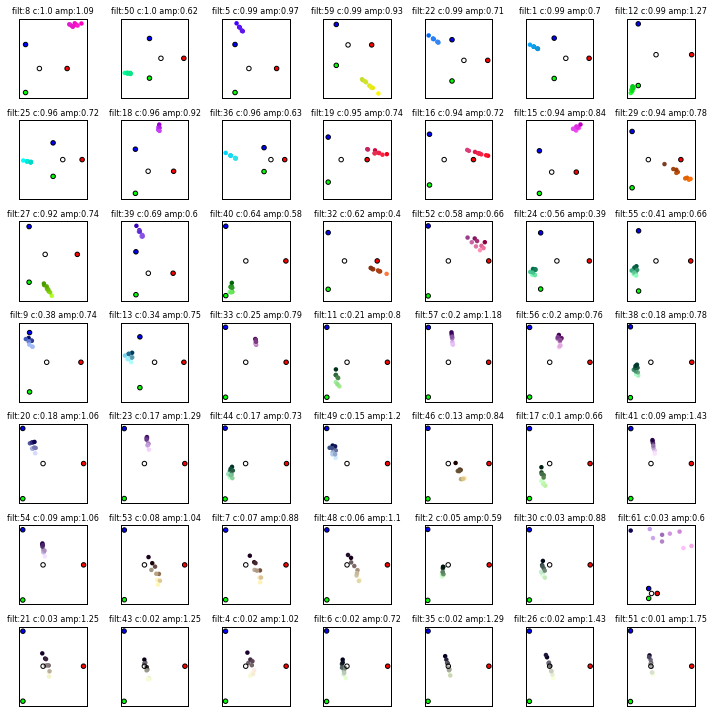

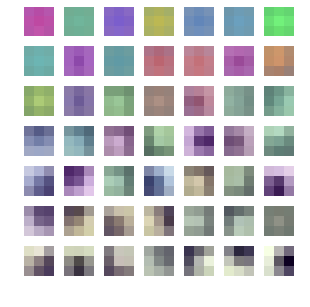

In [9]:
c = np.array([chrom_index(im) for im in wts])
wts_c = wts - np.mean(wts,-1,keepdims=True)
#our reference points for plotting in the 2-d space
rgb = np.eye(3) 
axis1 = np.real(np.fft.ifft([0,1,0]))
axis2 = np.imag(np.fft.fft([0,1,0]))
proj_mat = np.vstack([axis1 ,axis2]).T
proj_mat /= np.sum(proj_mat**2,0,keepdims=True)**0.5
rgb_proj = np.dot(rgb, proj_mat)/1.

fig, axs = plt.subplots(figsize=(10,10), nrows=7, ncols=7)
for ax, c_ind in zip(axs.ravel(), c.argsort()[::-1]):
    to_proj = wts[c_ind].squeeze()
    amp = np.sum(to_proj**2)**0.5
    to_proj = to_proj/np.max(to_proj)
    to_proj = to_proj.reshape(np.product(to_proj.shape[:-1]),3)
    proj = np.dot(to_proj, proj_mat)
    color = np.array(to_proj - np.min(to_proj))
    color /= np.max(color)
    _=ax.scatter(proj[:, 0], proj[:, 1], c=color, linewidths=0)
    _=ax.scatter(0, 0, c='none', linewidths=1);_=plt.axis('equal')
    ax.set_title('filt:'+str(c_ind) +' c:'+ str(np.round(c[c_ind],2)) +
                 ' amp:' + str(np.round(amp,2)), fontsize=8)
    #for spine in ['left', 'right', 'bottom', 'top']:
    #    ax.spines[spine].set_visible(False)
    _=ax.scatter(rgb_proj[:,0], rgb_proj[:,1], c=rgb, linewidths=1)
    ax.set_xticks([]);ax.set_yticks([]);ax.axis('equal')
plt.tight_layout()
fig, ax = plt.subplots(figsize=(5,5), nrows=1, ncols=1)
vis_square(ax, wts[c.argsort()[::-1][:len(axs.ravel())]])

Figure 3. Here scatters in the chroma plane for each filter are sorted by their chromatic index. Each point is colored, with the color corresponding to its pixel, except that it has been normalized with respect to the filter, not all filters, thus colors are in some sense 'exaggerated'. An initial striking observation is that most have a clear orientation preference in the chromatic plane, and for the purely chromatic filters actually only vary in one dimension though three are available.

We have found that the initial filters of AlexNet are largely either chromatic or luminant, and that this division falls along a grouping parameter. One other noticeable difference among the filters is their orientation preference, and different frequency bands. Upon examination it would appear the chromatic are lower frequency than the luminant

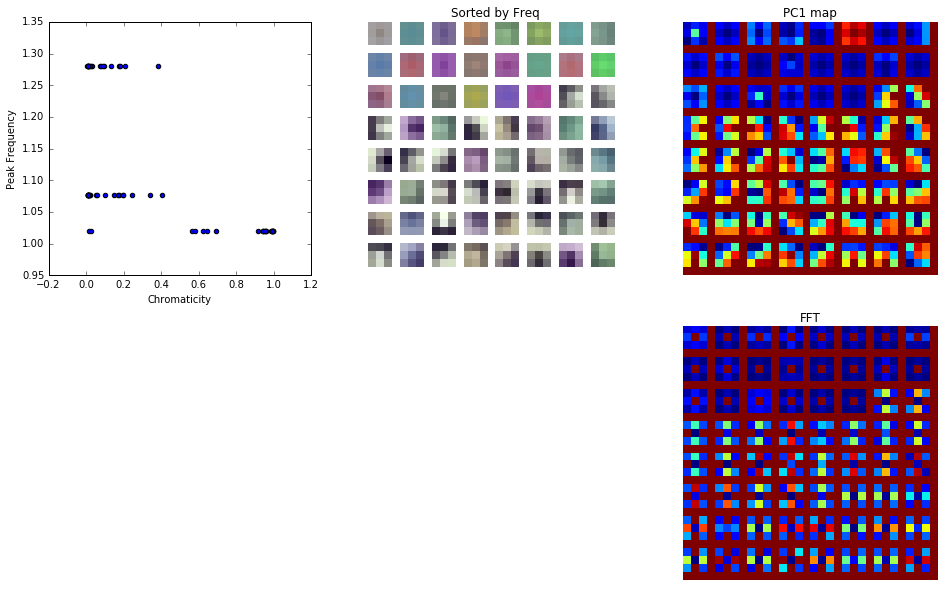

In [10]:
c = np.array([chrom_index(im) for im in wts])

val_map = []
for a_filter in wts:
    a_filter_unwrap = a_filter.reshape(np.product(a_filter.shape[:-1]),3)
    u,s, v = np.linalg.svd(a_filter_unwrap, full_matrices=False)
    val_map.append(np.dot(a_filter_unwrap, v[0,:]).reshape(np.shape(a_filter)[:-1]))
val_map = np.array(val_map)
ft_val_map = np.abs(np.fft.fft2(val_map))

ft_val_map = np.array([np.fft.fftshift(a_map) for a_map in ft_val_map])
index = np.linspace(-1,1,11)
x, y = np.meshgrid(index,index)
y = np.abs(y)#complex conjugate
freq = (x**2 + y**2)**0.5
orientation = np.angle(x+y*1j)

top_freq = np.array([freq.ravel()[a_map.ravel().argmax()] for a_map in ft_val_map])
plt.figure(figsize=(16,10))
ax = plt.subplot(231)
ax.scatter(c,top_freq)
ax.set_xlabel('Chromaticity')
ax.set_ylabel('Peak Frequency')
ax = plt.subplot(232)
sort_freq = np.array([wts[freq_ind] for freq_ind in np.argsort(top_freq)])
vis_square(ax, sort_freq)
ax.set_title('Sorted by Freq')

ax = plt.subplot(233)
sort_freq = np.array([val_map[freq_ind]/np.abs(val_map[freq_ind]).max() for freq_ind in np.argsort(top_freq)])
vis_square(ax, sort_freq)
ax.set_title('PC1 map')

ax = plt.subplot(236)
sort_freq = np.array([ft_val_map[freq_ind]/np.abs(ft_val_map[freq_ind]).max() for freq_ind in np.argsort(top_freq)])
vis_square(ax, sort_freq)
ax.set_title('FFT')

Figure X)  
Because the kernels have three channels, but the majority of the variance is along one dimension in rgb space we used PCA to calculate the channel values along which the image varies the most, then calculated those intensity maps, then from those we got the fft, then took the peak absolute value of the fft as the preferred frequency.
Plotting chromaticity against preferred frequency our intuition was correct that chromatic filters tend to be lower frequency.

<h4>Spatial Frequency and Orientation</h4>
Another qualitative observation is that the filters seem to have good coverage of orientations and frequencies

In [11]:
def min_or_dif(a, b):
    nonconj = np.exp(1j*a) * np.exp(-1j*b)
    conj = np.exp(1j*a) * -np.exp(-1j*b)
    return  np.min(np.array([np.abs(np.angle(conj)), np.abs(np.angle(nonconj))]),0)

peak_ori = [orientation.ravel()[np.argmax(a_filter)] for a_filter in ft_val_map]
peak_freq = [freq.ravel()[np.argmax(a_filter)] for a_filter in ft_val_map]
#print(np.round(peak_ori,2))
#bandwidth
bandwidth =[(a_filter.ravel()[freq.ravel()!=0].max()*2)/a_filter.sum() for a_filter in ft_val_map]

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 9 but corresponding boolean dimension is 121


IndexError: index 9 is out of bounds for axis 1 with size 9

In [ ]:
plt.figure(figsize=(10,10))

for ind, a_peak_ori, a_bw, a_filter in zip(range(len(peak_ori)), peak_ori, bandwidth, ft_val_map):
    ax = plt.subplot(10, 10, ind+1)
    ax.imshow(a_filter, interpolation='none')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title( str(np.round(np.rad2deg(a_peak_ori))) + ' '+ str(np.round(a_bw,2)), fontsize=10)
plt.tight_layout()

In [ ]:
plt.scatter(np.rad2deg(peak_ori), peak_freq, alpha=0.3)
plt.ylabel('Frequency');plt.xlabel('Orientation (deg)')
plt.xlim(-10,190);plt.ylim(-0.1,1.2)

#print(np.rad2deg(peak_ori))
#plt.imshow(val_map[4])


<h4>Second layer</h4>
With a good sense of the structure in the first layer we can now ask how the 2nd layer makes use of this structure. The second layer has weight dims:(256, 48, 5, 5), 48 channels! Thus it will be harder to make the qualitative observations that were so helpful in the first layer.
Lets start with some guesses from properties of V1, the first guess is that we might expect to see cross orientation suppression.
Lets take a second to go over how the first layer outputs are transformed before the 2nd layer weights are applied: first they are rectified, so only positive values come in, thus negative weights in the second layer are purely inhibitory, i.e. decrease the response. Then they are max pooled so over a 3x3 neigborhood only the best response from each filter is taken. Then the channels are normalized over their 5 nearest neighbors in the index of filters, this should bring the outputs into a similar range and perhaps produce some co-adaption between filters? In this last step we might expect to see some effect of cross-orientation suppression, except that it would require every neigborhood of 5 to be at 90 degree angles to each other, which would mean all filters would need to be at 90 degrees to each other. This is not the case thus the first opportunity for cross orientation suppression will be in the weights of the 2nd layer. One way to examine this is to plot the weights of the second layer, indexed by the orientation of their inputs.

In [ ]:
lay1_1 = np.array(peak_ori[:48])
lay1_2 = peak_ori[48:]
lay2 = a[1][1]
lay2 = lay2.reshape(256,48,25)
lay2_1 = lay2[:128]
lay2_1 -= lay2_1.mean(1, keepdims=True)
lay2_2 = lay2[128:]
lay2_2 -= lay2_2.mean(1, keepdims=True)

freq=0.5
A = np.vstack([np.cos(lay1_1*freq), np.sin(lay1_1*freq), np.ones(len(lay1_1))]).T
fit = [np.linalg.lstsq(A, a_filt)[:2] for a_filt in lay2_1]
frac_var_tot1 = [1 - a_fit[1].sum()/np.sum(a_filt**2) for a_fit,a_filt in zip(fit, lay2_1)]

A = np.vstack([np.cos(lay1_2*1), np.sin(lay1_2*1), np.ones(len(lay1_2))]).T
fit = [np.linalg.lstsq(A, a_filt)[:2] for a_filt in lay2_2]
frac_var_tot2 = [1 - a_fit[1].sum()/np.sum(a_filt**2) for a_fit,a_filt in zip(fit, lay2_2)]

In [ ]:
ax = plt.subplot(111)
x = np.sort(np.array(frac_var_tot1).ravel())
d_hist(ax, x, bins='auto', alpha=0.5, color='k', lw=2, normed=True, cumulative=True)
beautify(ax);ax.set_xlim(0,1);ax.set_ylim(0,1.1)
ax.set_title('All Spatial Positions Correlation to Sinusoid')
ax.set_ylabel('Fraction Positions')
ax.set_xlabel('Correlation')
ax.grid()
